In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F
import statistics

In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
epochs = 50
batch_size = 64
classes = ('0','1','2','3','4','5','6','7','8','9')

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
train_val_dataset = datasets.SVHN('.', download=True, split="train", transform=transform)
test_dataset = datasets.SVHN('.', download=True, split="test", transform=transform)
ratio = 0.2
train_examples = int((1.0-ratio)*len(train_val_dataset))
val_examples = int(ratio*len(train_val_dataset))+1
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_val_dataset,[train_examples,val_examples])
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset,batch_size=64,shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat


In [0]:
def plot_graph(training_losses,val_losses,epochs,string):
    plt.figure()
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.title(string + 'per epoch')
    plt.xlabel('Epoch')
    plt.ylabel(string)

# Classifier

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32,64 ,3)
        self.conv3 = nn.Conv2d(64,128,3)

        self.fc1 = nn.Linear(86528, 128)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(128,64)
        self.fc2_drop = nn.Dropout2d(p=0.5)
        self.fc3 = nn.Linear(64,10)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        #x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
        x = F.leaky_relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 12, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(12, 24, 4, stride=2, padding=1)

        self.fc1 = nn.Linear(1536, 500)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(500,50)
        self.fc2_drop = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(50,10)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        #x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = x.view(x.size(0),-1)
        x = F.leaky_relu(self.fc1_drop(self.fc1(x)))
        x = F.leaky_relu(self.fc2_drop(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [0]:
model1 = Classifier().cuda()
optimizer = optim.Adam(model1.parameters(),lr=0.001)
#optimizer = optim.ASGD(model1.parameters(),lr=0.01)
#optimizer = optim.Adagrad(model1.parameters(),lr=0.01)
#optimizer = optim.SGD(model1.parameters(),lr=0.01,momentum=0.9)
criterion = nn.CrossEntropyLoss()
training_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(epochs):
    #train
    print("Epoch", epoch)
    model1.train()
    train_epoch_loss = 0
    train_correct = 0
    for index, (images,labels) in enumerate(trainloader):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        class_train_output = model1(images)
        loss = criterion(class_train_output,labels)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = class_train_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))
    
    #validate
    model1.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(), labels.cuda()
            class_val_output = model1(images)
            loss = criterion(class_val_output,labels)
            val_epoch_loss += loss.item()
            pred = class_val_output.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 1.6945, Training Accuracy: 24033/58605 (41%)
Average validation loss: 0.6483, Testing Accuracy: 12049/14652 (82%)
Epoch 1
Average training loss: 0.7200, Training Accuracy: 46102/58605 (79%)
Average validation loss: 0.4892, Testing Accuracy: 12539/14652 (86%)
Epoch 2
Average training loss: 0.5560, Training Accuracy: 49110/58605 (84%)
Average validation loss: 0.3905, Testing Accuracy: 12986/14652 (89%)
Epoch 3
Average training loss: 0.4730, Training Accuracy: 50546/58605 (86%)
Average validation loss: 0.3691, Testing Accuracy: 13100/14652 (89%)
Epoch 4
Average training loss: 0.4202, Training Accuracy: 51539/58605 (88%)
Average validation loss: 0.3515, Testing Accuracy: 13205/14652 (90%)
Epoch 5
Average training loss: 0.3779, Training Accuracy: 52282/58605 (89%)
Average validation loss: 0.3617, Testing Accuracy: 13171/14652 (90%)
Epoch 6
Average training loss: 0.3379, Training Accuracy: 52789/58605 (90%)
Average validation loss: 0.3603, Testing Accuracy: 132

Lowest validation loss 0.35539507400651166
Lowest training loss 0.08074095214800461
Average test loss: 0.8518, Testing Accuracy: 23017/26032 (88%)


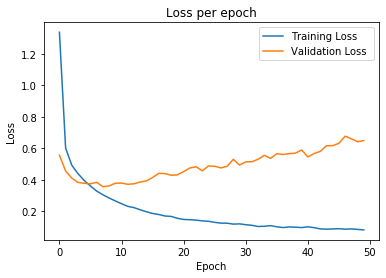

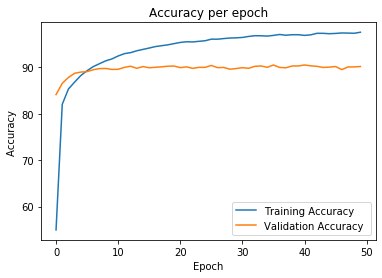

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
print("Lowest validation loss", min(val_losses))
print("Lowest training loss", min(training_losses))
model1.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
  for images, labels in testloader:
    images, labels = images.cuda(), labels.cuda()
    class_test_output = model1(images)
    loss = criterion(class_test_output,labels)
    test_epoch_loss += loss.item()
    pred = class_test_output.max(1, keepdim=True)[1] # get the index of the max log-probability
    test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average test loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
    test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

# Autoencoder

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32,64 ,3)
        self.conv3 = nn.Conv2d(64,128,3)
        self.deconv1 = nn.ConvTranspose2d(128,64,3)
        self.deconv2 = nn.ConvTranspose2d(64,32,3)
        self.deconv3 = nn.ConvTranspose2d(32,3,3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        encoded = F.relu(self.conv3(x))
        decoded = F.relu(self.deconv1(encoded))
        decoded = F.relu(self.deconv2(decoded))
        decoded = F.relu(self.deconv3(decoded))
        return torch.sigmoid(decoded)

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(12, 24, 4, stride=2, padding=1)
        self.deconv1 = nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        encoded = F.leaky_relu(self.conv2(x))
        decoded = F.leaky_relu(self.deconv1(encoded))
        decoded = F.leaky_relu(self.deconv2(decoded))
        return torch.sigmoid(decoded)

In [0]:
model2 = AutoEncoder().cuda()
#optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.ASGD(model2.parameters(),lr=0.01)
#optimizer = optim.Adagrad(model2.parameters(),lr=0.01)
optimizer = optim.Adam(model2.parameters(),lr=0.001)
criterion = nn.MSELoss()
training_losses = []
val_losses = []
for epoch in range(epochs):
    #train
    print("Epoch", epoch)
    model2.train()
    train_epoch_loss = 0
    for index, (images,labels) in enumerate(trainloader):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        auto_train_output = model2(images)
        loss = criterion(auto_train_output,images)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
    train_epoch_loss /= len(trainloader)
    print("Average training loss:",train_epoch_loss)
    training_losses.append(train_epoch_loss)
    
    #validate
    model2.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(), labels.cuda()
            auto_val_output = model2(images)
            loss = criterion(auto_val_output,images)
            val_epoch_loss += loss.item()
    val_epoch_loss /= len(valloader)
    print('Average testing loss: {:.4f}'.format(val_epoch_loss))
    val_losses.append(val_epoch_loss)

Epoch 0
Average training loss: 0.027604238166754422
Average testing loss: 0.0272
Epoch 1
Average training loss: 0.026979174708955674
Average testing loss: 0.0268
Epoch 2
Average training loss: 0.026942493129668017
Average testing loss: 0.0268
Epoch 3
Average training loss: 0.026919648586060673
Average testing loss: 0.0268
Epoch 4
Average training loss: 0.026905922526208985
Average testing loss: 0.0268
Epoch 5
Average training loss: 0.026902259085490064
Average testing loss: 0.0268
Epoch 6
Average training loss: 0.02689734135864213
Average testing loss: 0.0268
Epoch 7
Average training loss: 0.026888532964634712
Average testing loss: 0.0268
Epoch 8
Average training loss: 0.026882619838998957
Average testing loss: 0.0268
Epoch 9
Average training loss: 0.02689178764624887
Average testing loss: 0.0268
Epoch 10
Average training loss: 0.026877209176126397
Average testing loss: 0.0268
Epoch 11
Average training loss: 0.02687959628195937
Average testing loss: 0.0268
Epoch 12
Average training los

Average testing loss: 0.0321


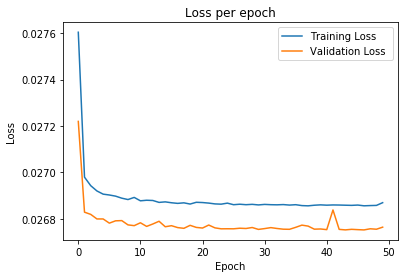

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
model2.eval()
test_epoch_loss = 0
with torch.no_grad():
      for images, labels in testloader:
          images, labels = images.cuda(), labels.cuda()
          auto_test_output = model2(images)
          loss = criterion(auto_test_output,images)
          test_epoch_loss += loss.item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}'.format(test_epoch_loss))

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


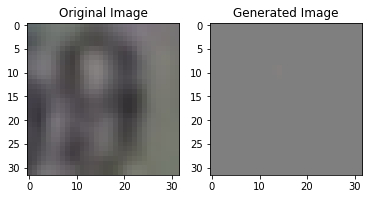

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


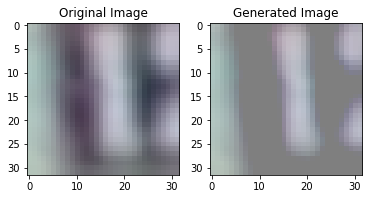

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


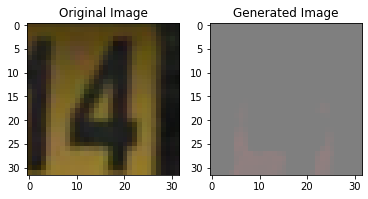

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


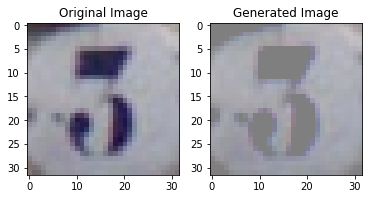

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


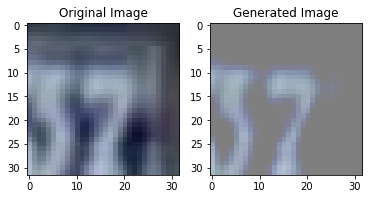

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


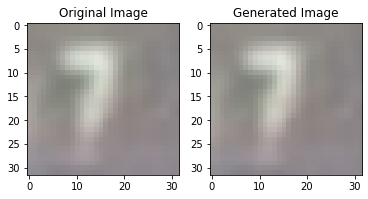

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


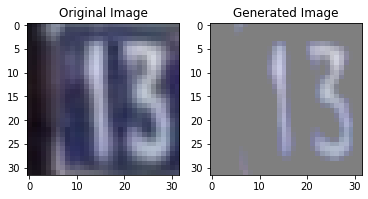

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


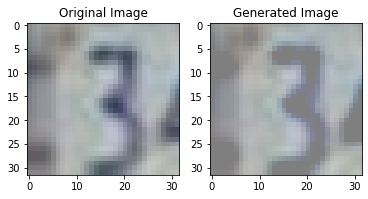

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


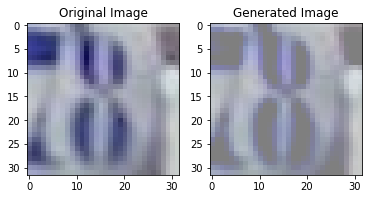

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


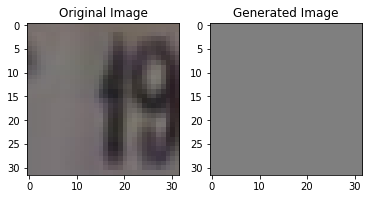

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


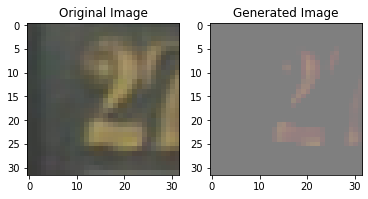

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


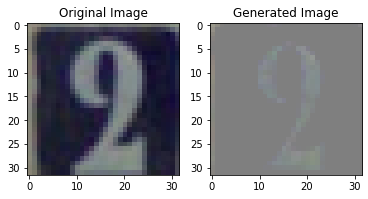

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


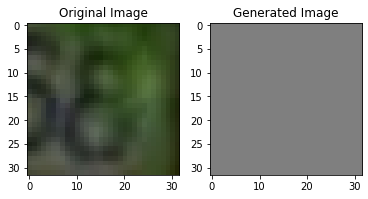

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


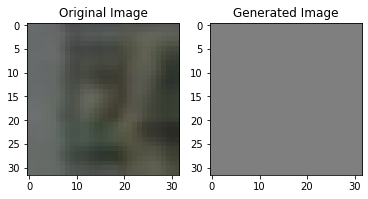

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


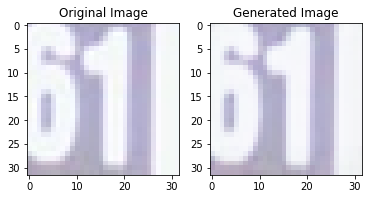

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


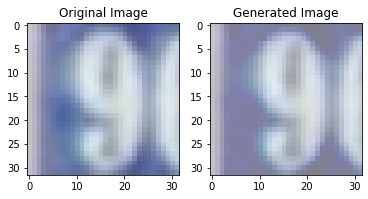

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


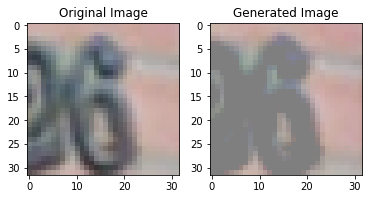

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


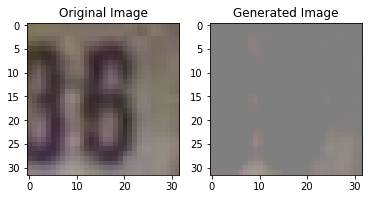

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


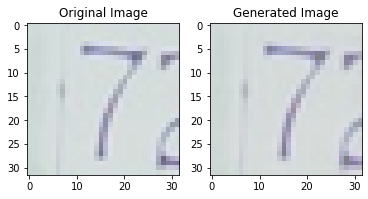

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


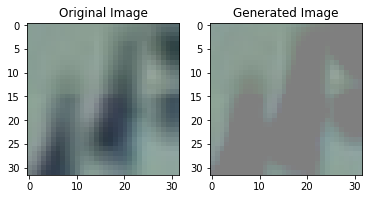

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


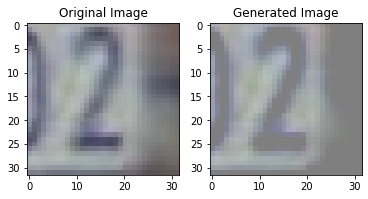

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


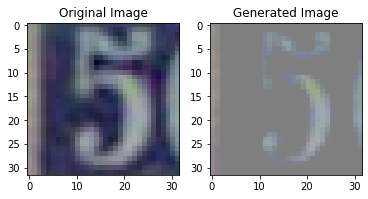

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


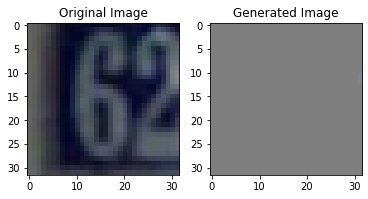

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


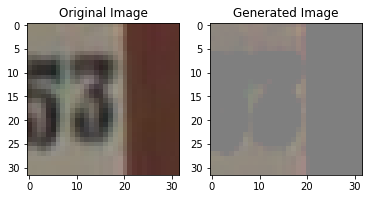

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


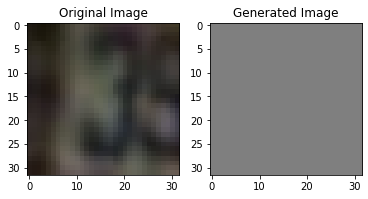

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


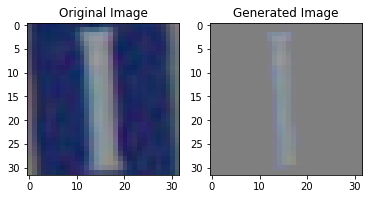

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


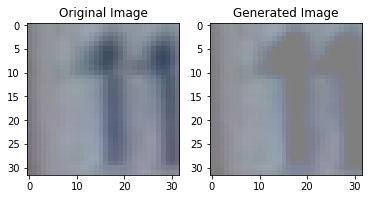

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


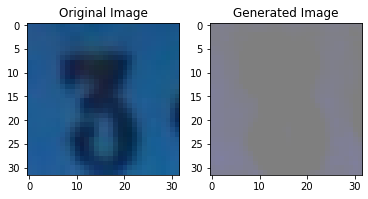

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


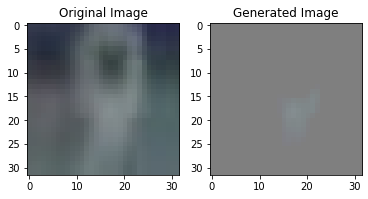

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


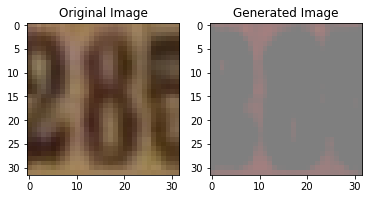

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


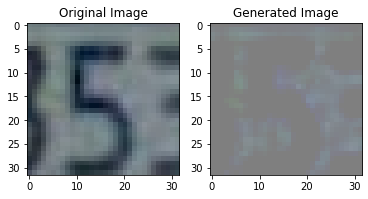

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


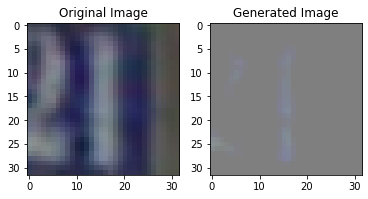

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


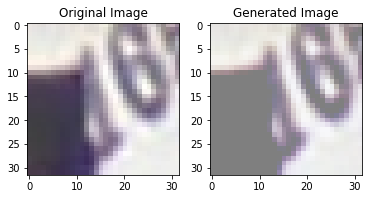

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


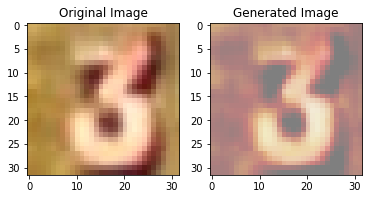

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


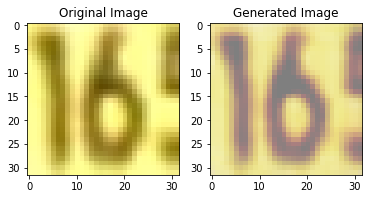

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


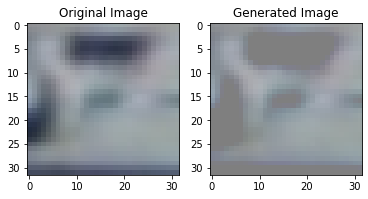

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


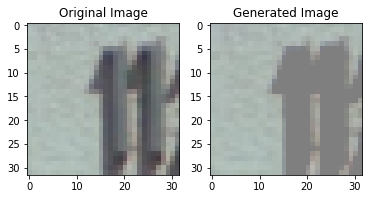

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


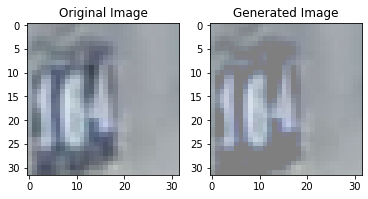

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


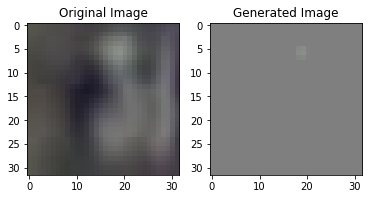

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


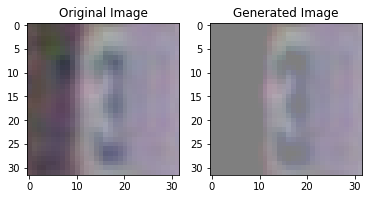

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


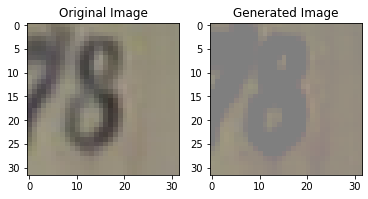

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


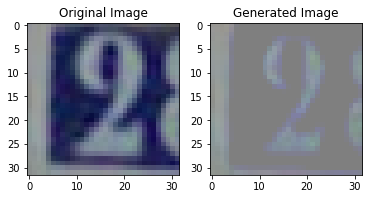

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


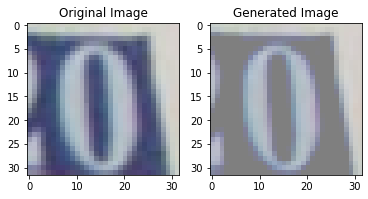

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


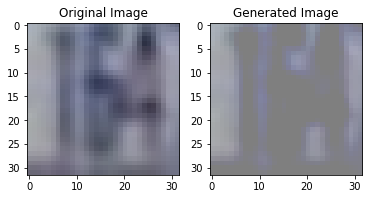

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


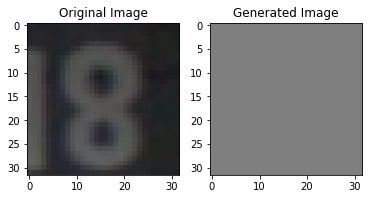

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


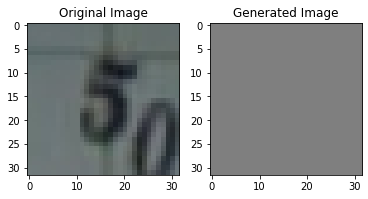

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


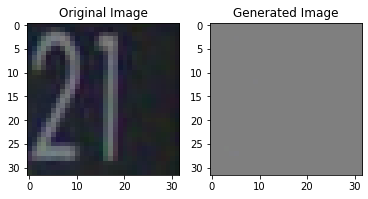

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


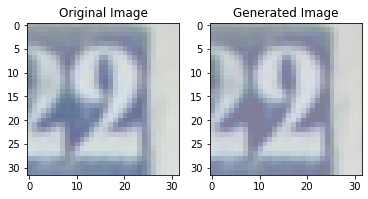

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


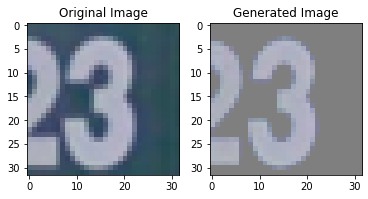

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


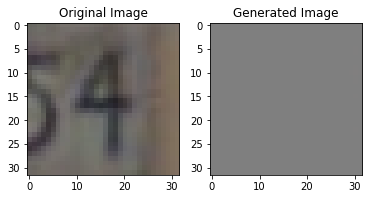

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


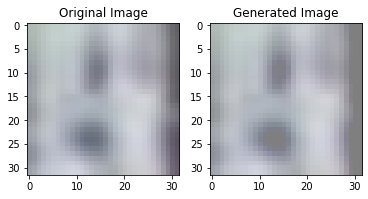

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


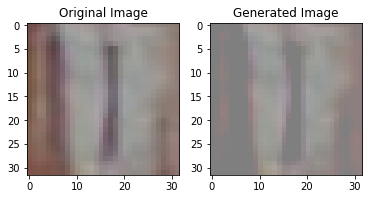

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


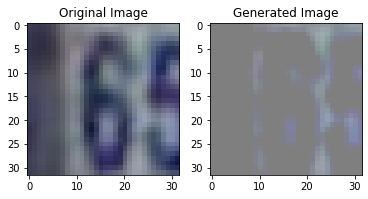

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


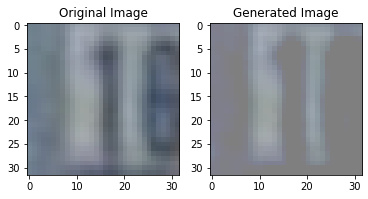

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


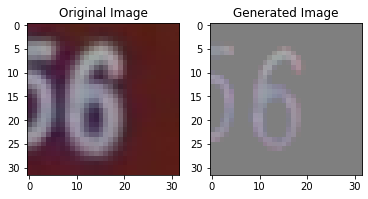

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


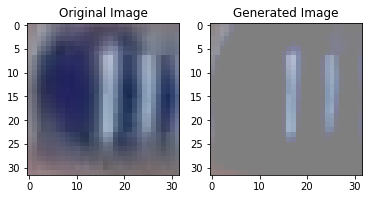

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


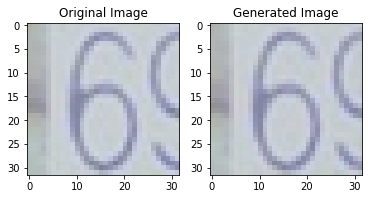

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


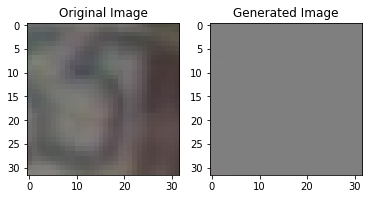

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


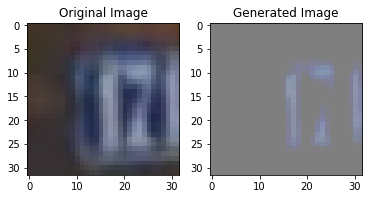

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


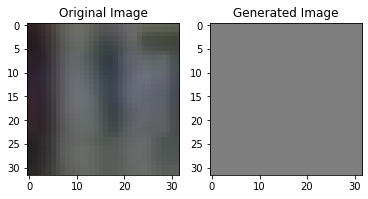

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


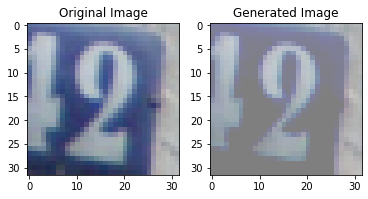

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


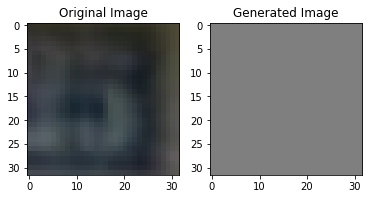

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


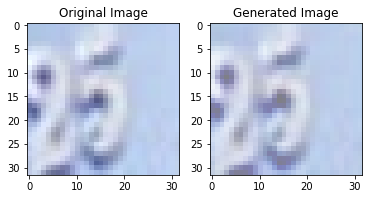

torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


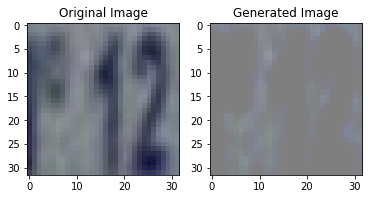

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output = model2(test_images)
#noisy_test_imgs = test_images + 0.1 * torch.randn(*test_images.shape)
#noisy_test_imgs = np.clip(noisy_test_imgs, 0., 1.)
#noisy_test_imgs = noisy_test_imgs.cuda()
#test_output = model(noisy_test_imgs)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    image_input = test_images[i]
    print(image_input.shape)
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    print(image_input.shape)
    image_output = test_output[i]
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(image_output)
    plt.show()

# Mixed model definitions

In [0]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()

        self.conv1 = nn.Conv2d(3, 32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,3)

        self.deconv1 = nn.ConvTranspose2d(128,64,3)
        self.deconv2 = nn.ConvTranspose2d(64,32,3)
        self.deconv3 = nn.ConvTranspose2d(32,3,3)

        self.fc1 = nn.Linear(86528, 256)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(256,64)
        self.fc2_drop = nn.Dropout2d(p=0.5)
        self.fc3 = nn.Linear(64,10)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        encoded = F.leaky_relu(self.conv3(x))
        decoded = F.leaky_relu(self.deconv1(encoded))
        decoded = F.leaky_relu(self.deconv2(decoded))
        decoded = F.leaky_relu(self.deconv3(decoded))
        flattened = encoded.view(encoded.size(0),-1)
        predicted = F.leaky_relu(self.fc1_drop(self.fc1(flattened)))
        predicted = F.leaky_relu(self.fc2_drop(self.fc2(predicted)))
        predicted = self.fc3(predicted)
        return torch.sigmoid(decoded), F.log_softmax(predicted, dim=1)

In [0]:
class Mixed(nn.Module):
    def __init__(self):
        super(Mixed, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(12, 24, 4, stride=2, padding=1)
        self.deconv1 = nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1)
        self.fc1 = nn.Linear(1536, 500)
        self.fc1_drop = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(500,50)
        self.fc2_drop = nn.Dropout2d(p=0.3)
        self.fc3 = nn.Linear(50,10)
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        encoded = F.leaky_relu(self.conv2(x))
        decoded = F.leaky_relu(self.deconv1(encoded))
        decoded = F.leaky_relu(self.deconv2(decoded))
        flattened = encoded.view(encoded.size(0),-1)
        predicted = F.leaky_relu(self.fc1_drop(self.fc1(flattened)))
        predicted = F.leaky_relu(self.fc2_drop(self.fc2(predicted)))
        predicted = self.fc3(predicted)
        return torch.sigmoid(decoded), F.log_softmax(predicted, dim=1)

# Mixed (autoencoder loss)

In [0]:
model3 = Mixed().to(device)
#optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model3.parameters(),lr=0.001)
training_losses = []
val_losses = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model3.train()
    train_epoch_loss = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded_auto_train_mixed,predicted = model3(images)
        loss = criterion1(decoded_auto_train_mixed,images)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print("Average training loss:",train_epoch_loss)
    training_losses.append(train_epoch_loss)

    #validate
    model3.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded_auto_val_mixed, predicted = model3(images)
            loss = criterion1(decoded_auto_val_mixed,images)
            val_epoch_loss += loss.item()
    val_epoch_loss /= len(valloader)
    print("Average validation loss:",val_epoch_loss)
    val_losses.append(val_epoch_loss)

Epoch 0
Average training loss: 0.004835304624820942
Average validation loss: 0.0024540290296460017
Epoch 1
Average training loss: 0.001117764146948705
Average validation loss: 0.0015340801829159033
Epoch 2
Average training loss: 0.0007980035002636682
Average validation loss: 0.0013298640298600182
Epoch 3
Average training loss: 0.0006271648161874791
Average validation loss: 0.0008687408999123054
Epoch 4
Average training loss: 0.0005086650194025265
Average validation loss: 0.0007665678721498779
Epoch 5
Average training loss: 0.00043779443209473855
Average validation loss: 0.0011876531160847329
Epoch 6
Average training loss: 0.00037229096199048776
Average validation loss: 0.0006084519247936215
Epoch 7
Average training loss: 0.000329699722869402
Average validation loss: 0.0005272790305006346
Epoch 8
Average training loss: 0.0003047754298319875
Average validation loss: 0.00054623719226512
Epoch 9
Average training loss: 0.00027734472306534713
Average validation loss: 0.0006936503143159583
Ep

Average testing loss: 5.120349265128021e-05


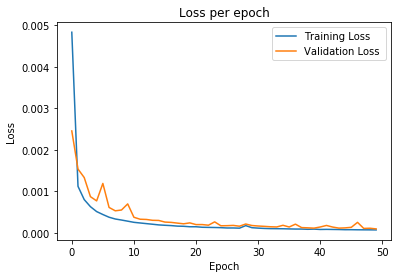

In [0]:
plot_graph(training_losses,val_losses,epochs, "Loss ")
model3.eval()
test_epoch_loss = 0
with torch.no_grad():
    for images, labels in testloader:
          images, labels = images.cuda(),labels.cuda()
          decoded_auto_test_mixed, predicted = model3(images)
          loss = criterion1(decoded_auto_test_mixed,images)
          test_epoch_loss += loss.item()
test_epoch_loss /= len(testloader)
print("Average testing loss:",test_epoch_loss)

In [0]:
train_mean_auto = statistics.mean(training_losses)
val_mean_auto = statistics.mean(val_losses)
train_std_auto = statistics.stdev(training_losses)
val_std_auto = statistics.stdev(val_losses)

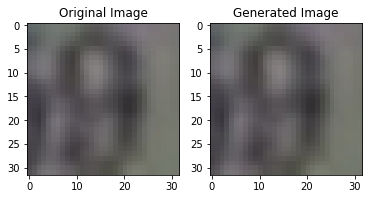

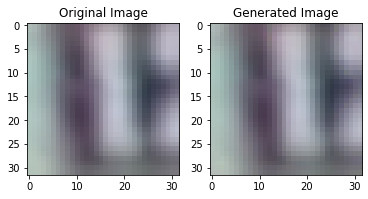

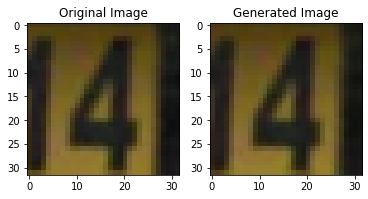

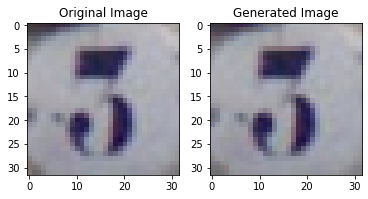

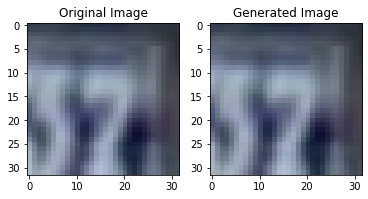

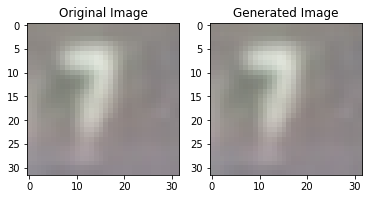

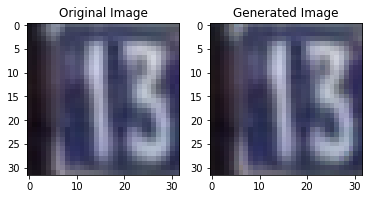

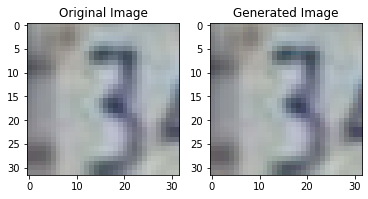

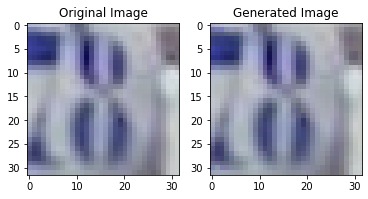

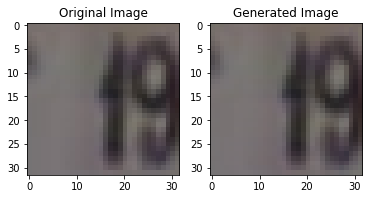

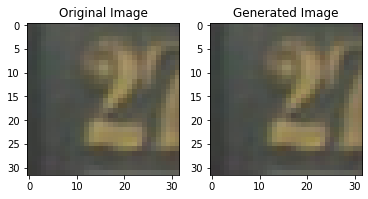

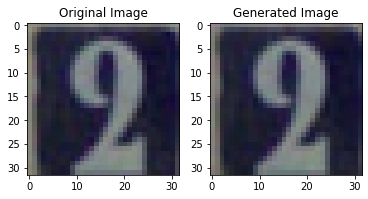

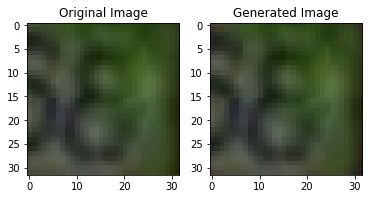

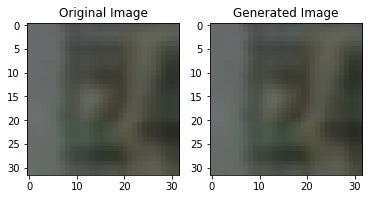

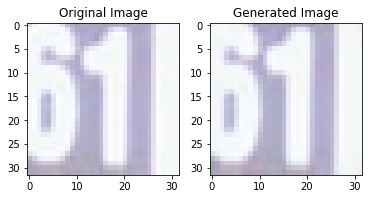

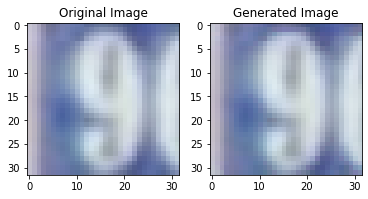

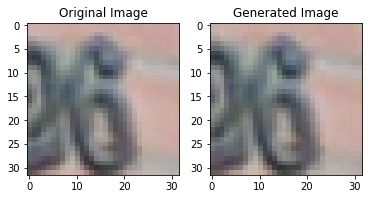

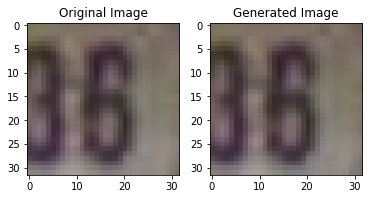

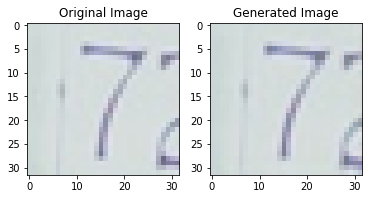

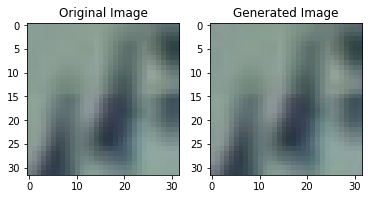

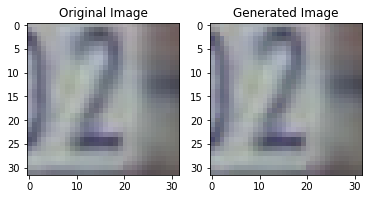

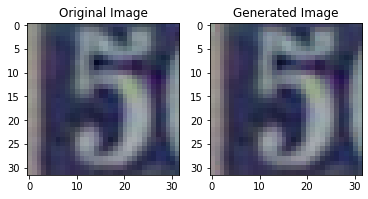

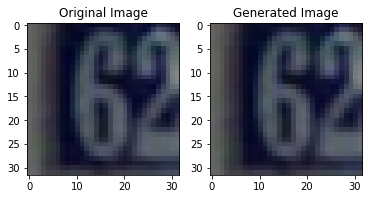

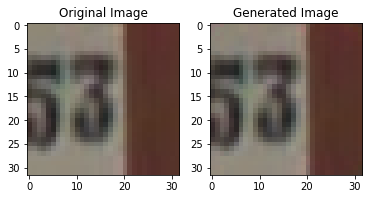

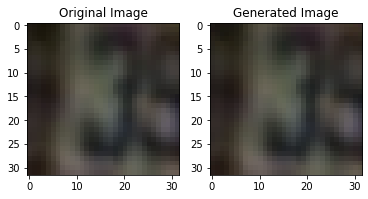

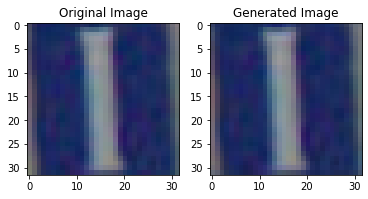

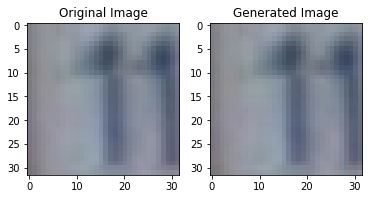

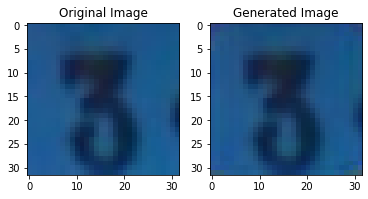

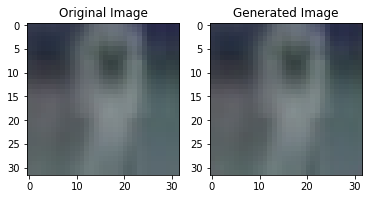

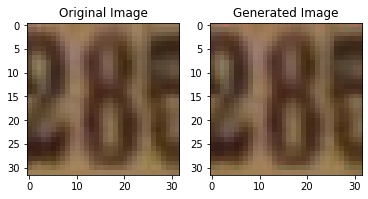

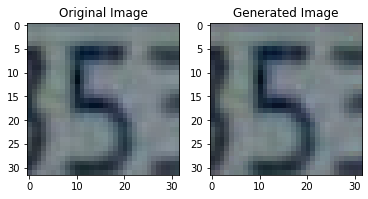

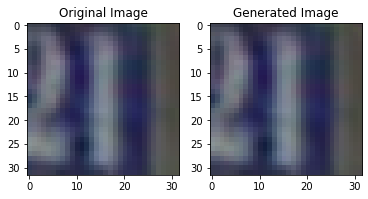

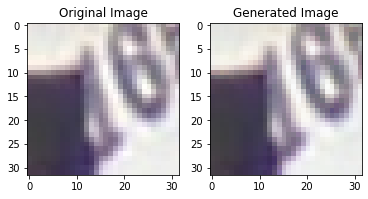

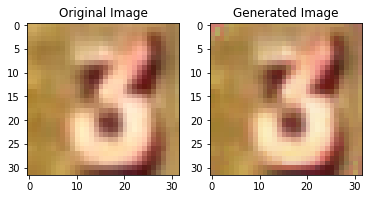

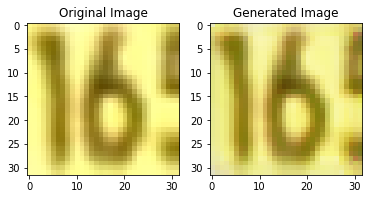

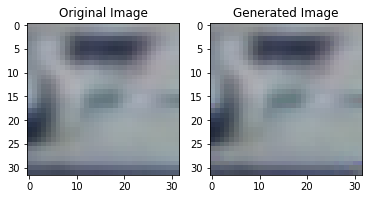

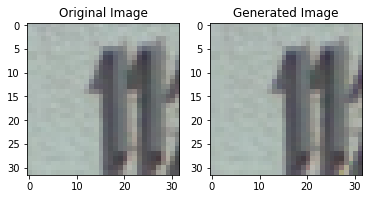

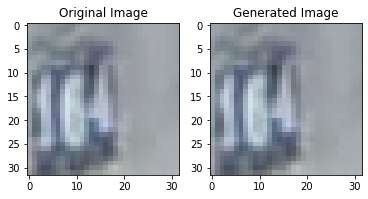

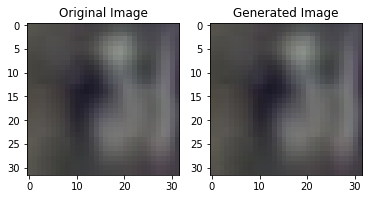

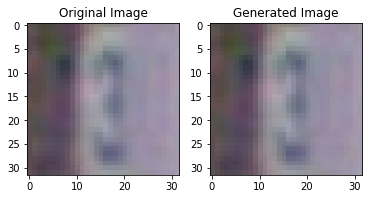

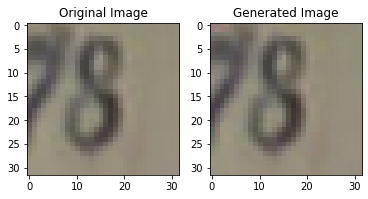

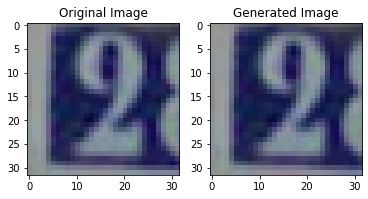

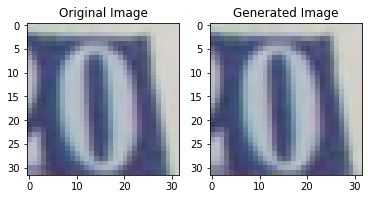

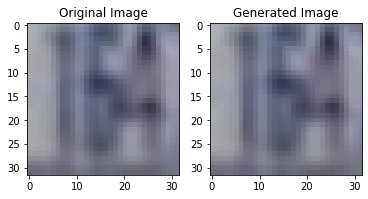

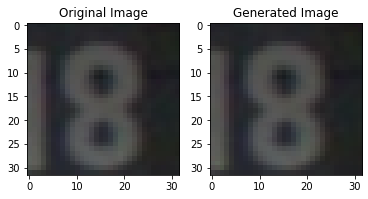

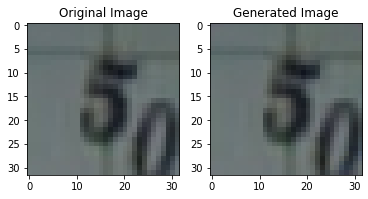

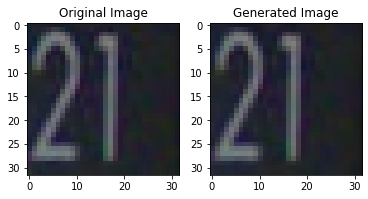

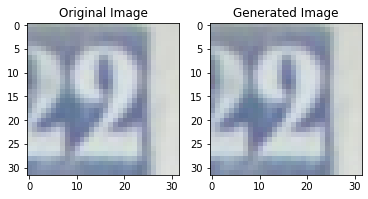

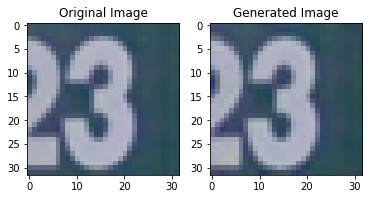

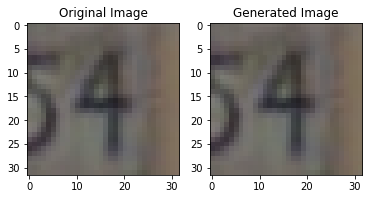

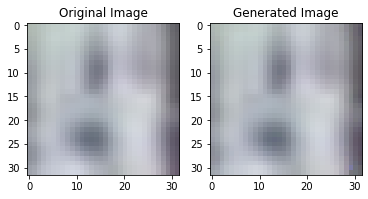

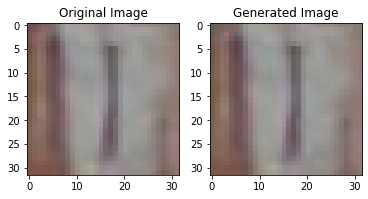

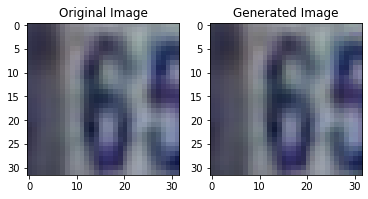

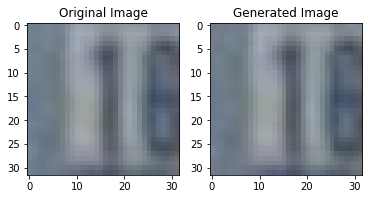

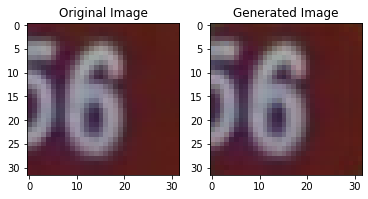

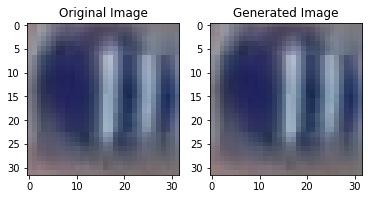

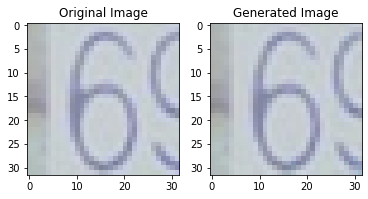

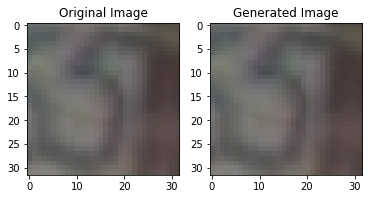

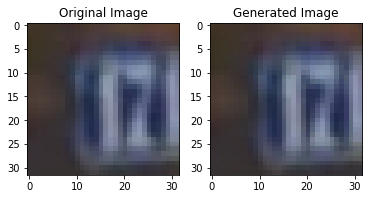

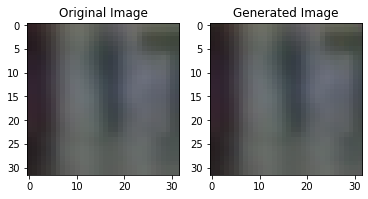

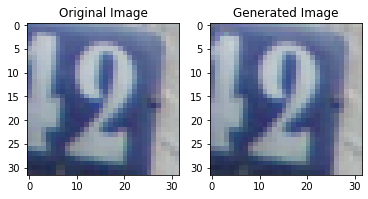

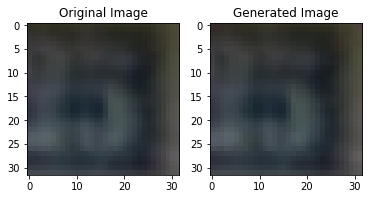

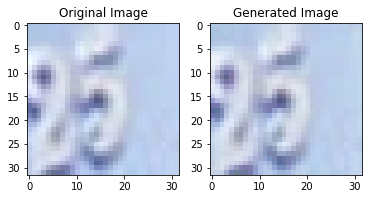

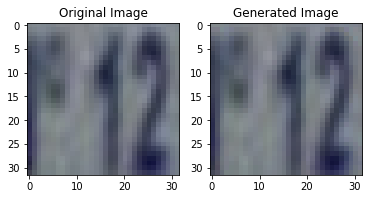

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model3(test_images)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    image_input = test_images[i]
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    image_output = test_output[i]
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(image_output)
    plt.show()

# Mixed (classifier loss)

In [0]:
model4 = Mixed().to(device)
#optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model4.parameters(),lr=0.001)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model4.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded,predicted = model4(images)
        loss = criterion2(predicted,labels)
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model4.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model4(images)
            loss = criterion2(predicted,labels)
            val_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 1.4496, Training Accuracy: 29477/58605 (50%)
Average validation loss: 0.5163, Validation Accuracy: 12460/14652 (85%)
Epoch 1
Average training loss: 0.5829, Training Accuracy: 48595/58605 (83%)
Average validation loss: 0.3977, Validation Accuracy: 12937/14652 (88%)
Epoch 2
Average training loss: 0.4602, Training Accuracy: 50726/58605 (87%)
Average validation loss: 0.3606, Validation Accuracy: 13122/14652 (90%)
Epoch 3
Average training loss: 0.3975, Training Accuracy: 51931/58605 (89%)
Average validation loss: 0.3340, Validation Accuracy: 13228/14652 (90%)
Epoch 4
Average training loss: 0.3404, Training Accuracy: 52869/58605 (90%)
Average validation loss: 0.3492, Validation Accuracy: 13230/14652 (90%)
Epoch 5
Average training loss: 0.2985, Training Accuracy: 53504/58605 (91%)
Average validation loss: 0.3974, Validation Accuracy: 12998/14652 (89%)
Epoch 6
Average training loss: 0.2684, Training Accuracy: 53978/58605 (92%)
Average validation loss: 0.3646, Val

Average validation loss: 0.6336, Validation Accuracy: 23171/26032 (89%)


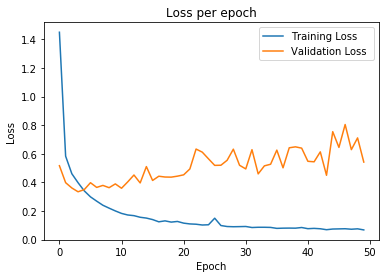

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
model4.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model4(images)
            loss = criterion2(predicted,labels)
            test_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

In [0]:
train_class_mean = statistics.mean(training_losses)
val_class_mean = statistics.mean(val_losses)
train_class_std = statistics.stdev(training_losses)
val_class_std = statistics.stdev(val_losses)

# Mixed (two losses - no scaling of losses, no feedback)

In [0]:
model5 = Mixed().to(device)
#optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model5.parameters(),lr=0.001)
training_losses = []
val_losses = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model5.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded_train_mixed,predicted = model5(images)
        loss1 = criterion1(decoded_train_mixed,images)
        loss2 = criterion2(predicted,labels)
        loss = loss1+loss2
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)

    #validate
    model5.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            decoded_val_mixed, predicted = model5(images)
            loss1 = criterion1(decoded_val_mixed,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            val_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)

Epoch 0
Average training loss: 1.3191, Training Accuracy: 32926/58605 (56%)
Average validation loss: 0.5577, Validation Accuracy: 12295/14652 (84%)
Epoch 1
Average training loss: 0.5839, Training Accuracy: 48795/58605 (83%)
Average validation loss: 0.4102, Validation Accuracy: 12935/14652 (88%)
Epoch 2
Average training loss: 0.4722, Training Accuracy: 50698/58605 (87%)
Average validation loss: 0.4028, Validation Accuracy: 12999/14652 (89%)
Epoch 3
Average training loss: 0.4055, Training Accuracy: 51849/58605 (88%)
Average validation loss: 0.3507, Validation Accuracy: 13251/14652 (90%)
Epoch 4
Average training loss: 0.3435, Training Accuracy: 52895/58605 (90%)
Average validation loss: 0.3360, Validation Accuracy: 13333/14652 (91%)
Epoch 5
Average training loss: 0.3065, Training Accuracy: 53609/58605 (91%)
Average validation loss: 0.3458, Validation Accuracy: 13291/14652 (91%)
Epoch 6
Average training loss: 0.2758, Training Accuracy: 54028/58605 (92%)
Average validation loss: 0.3703, Val

Average validation loss: 1.0641, Validation Accuracy: 23380/26032 (90%)


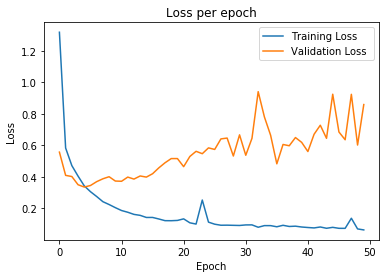

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
#plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model5.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded_test_mixed, predicted = model5(images)
            loss1 = criterion1(decoded_test_mixed,images)
            loss2 = criterion2(predicted,labels)
            loss = loss1+loss2
            test_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

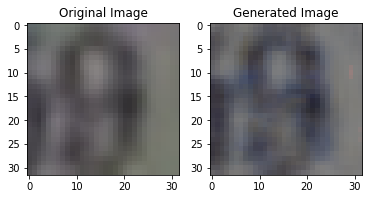

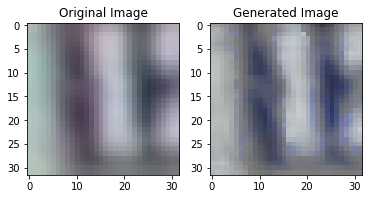

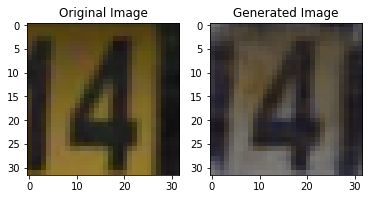

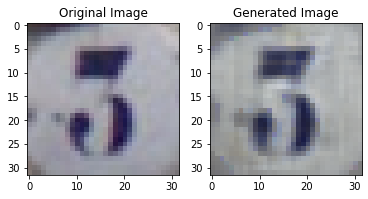

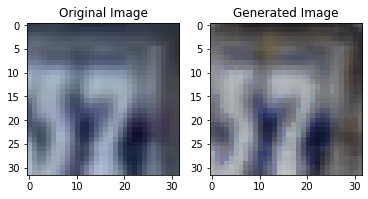

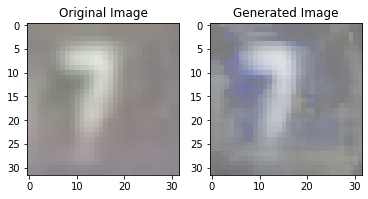

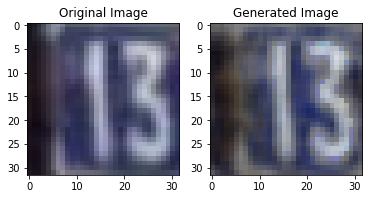

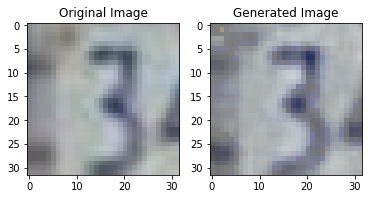

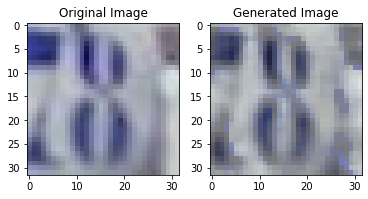

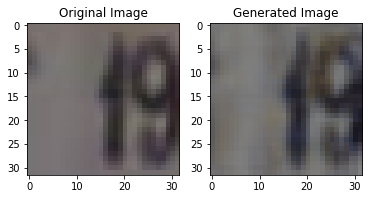

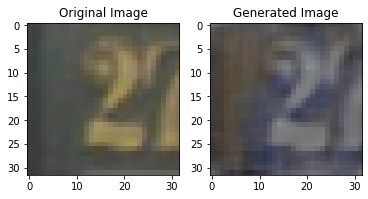

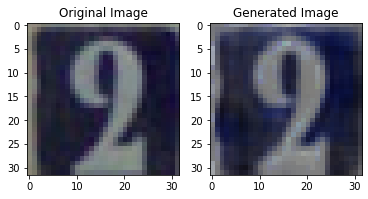

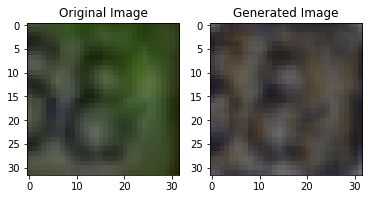

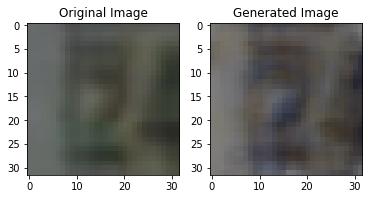

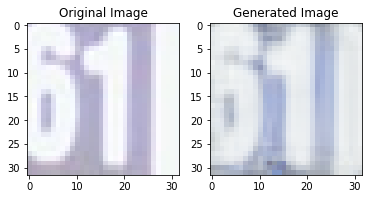

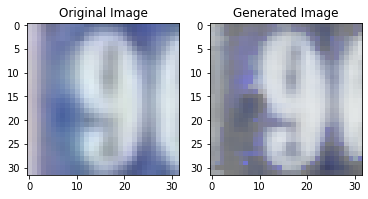

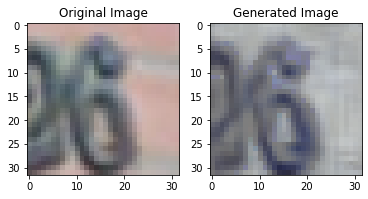

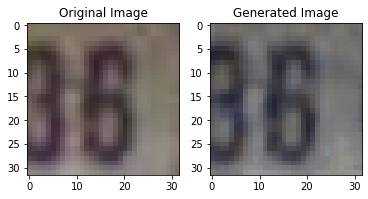

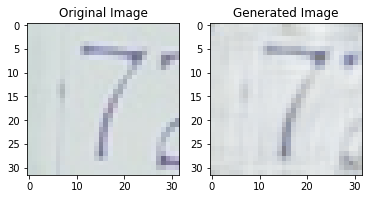

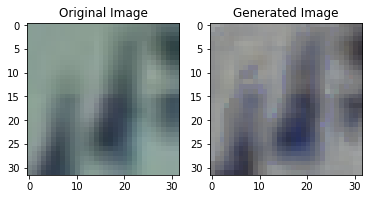

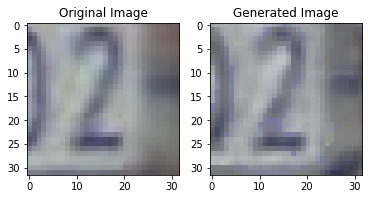

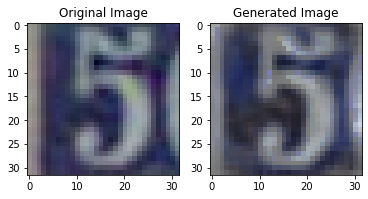

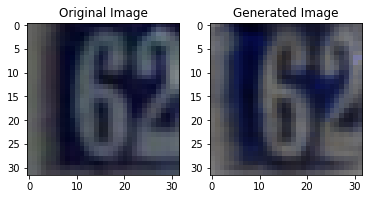

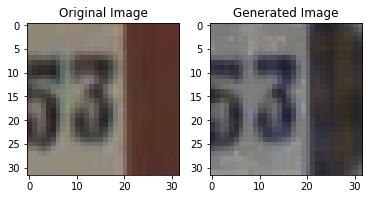

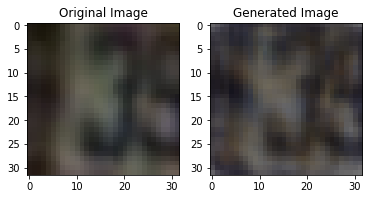

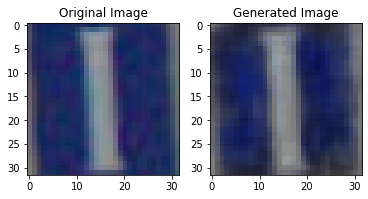

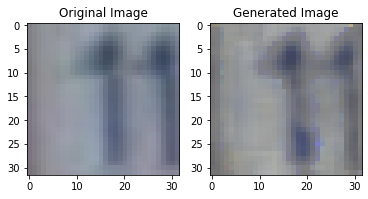

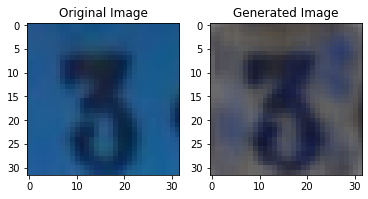

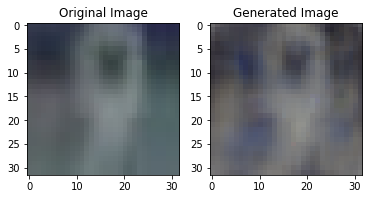

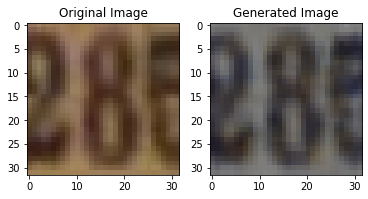

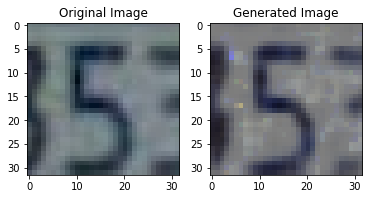

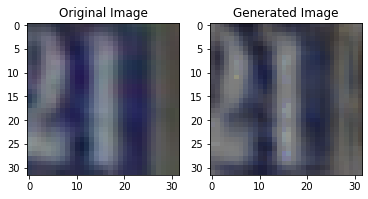

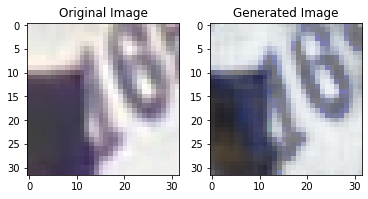

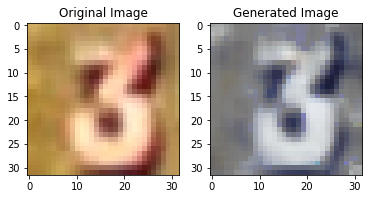

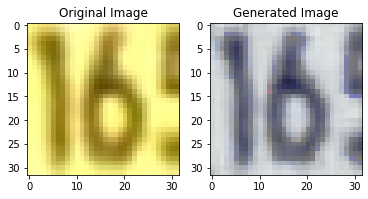

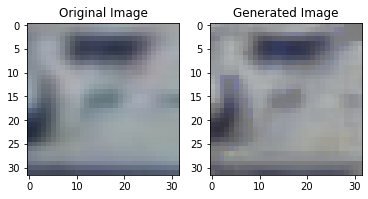

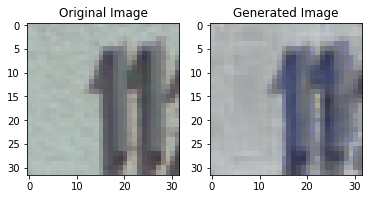

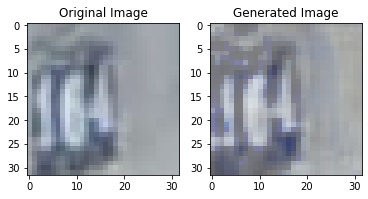

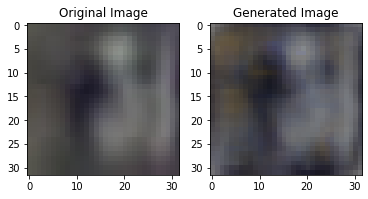

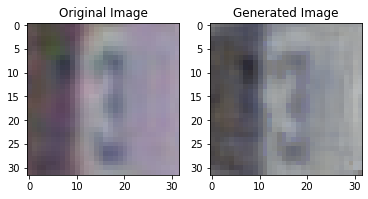

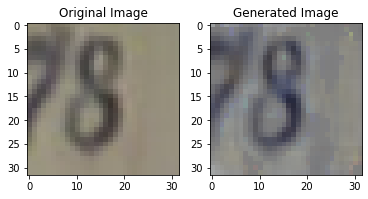

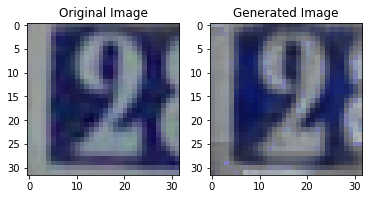

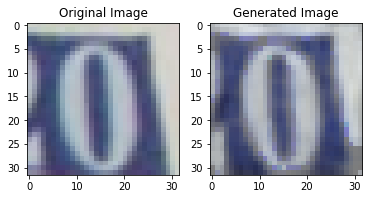

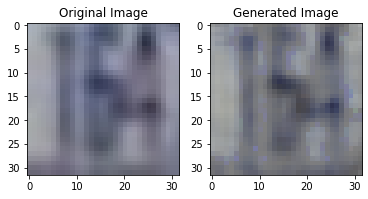

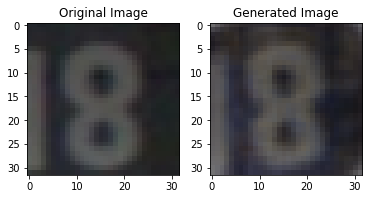

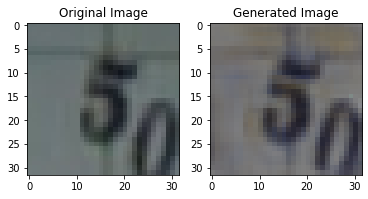

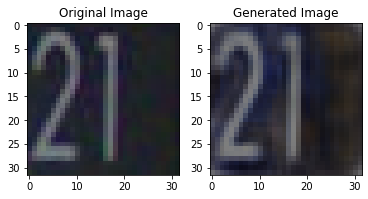

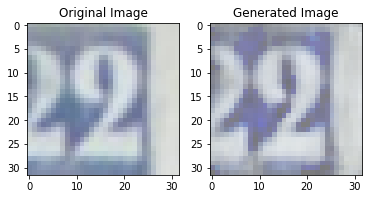

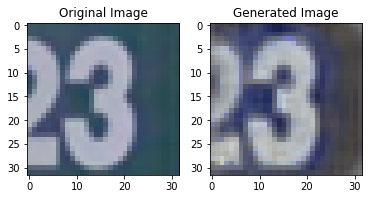

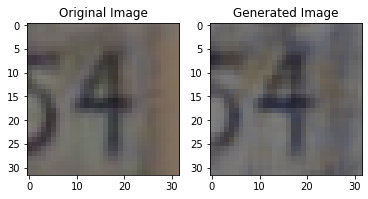

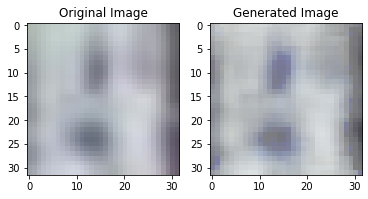

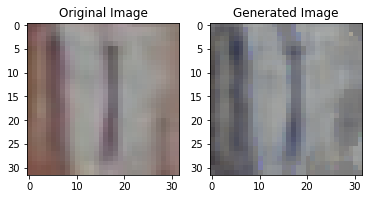

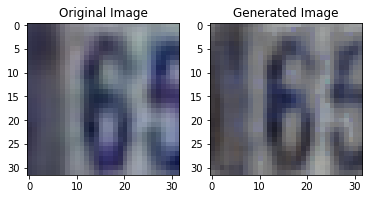

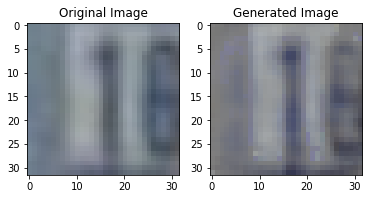

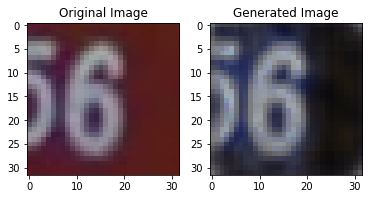

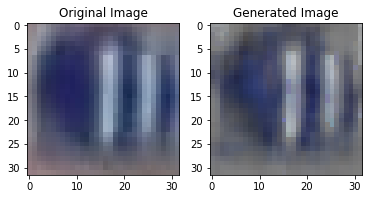

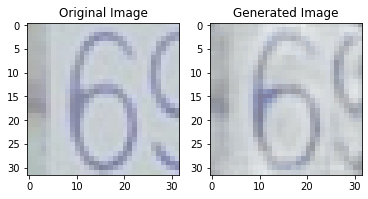

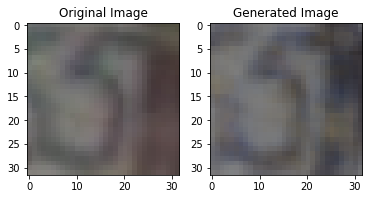

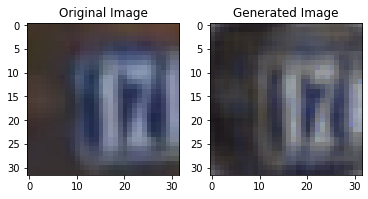

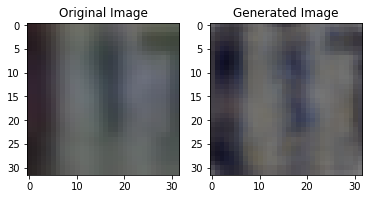

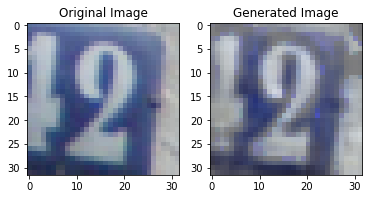

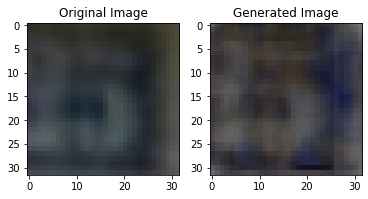

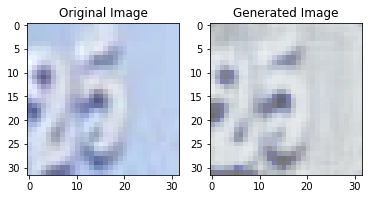

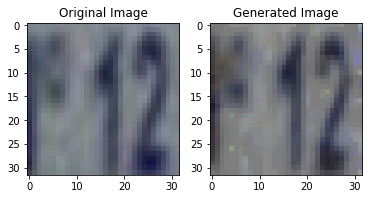

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model5(test_images)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    image_input = test_images[i]
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    image_output = test_output[i]
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(image_output)
    plt.show()

# Mixed model - with scaling of losses

In [0]:
model7 = Mixed().to(device)
#optimizer = optim.SGD(model7.parameters(),lr=0.01,momentum=0.9)
optimizer = optim.Adam(model7.parameters(),lr=0.001)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model7.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        decoded,predicted = model7(images)
        loss1 = (criterion1(decoded,images)-train_mean_auto)/train_std_auto
        loss2 = (criterion2(predicted,labels)-train_class_mean)/train_class_std
        loss = loss1+loss2
        loss.backward()
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model7.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model7(images)
            loss1 = (criterion1(decoded,images)-val_mean_auto)/val_std_auto
            loss2 = (criterion2(predicted,labels)-val_class_mean)/val_class_std
            loss = loss1+loss2
            val_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 17.1507, Training Accuracy: 10658/58605 (18%)
Average validation loss: 18.4284, Validation Accuracy: 2746/14652 (19%)
Epoch 1
Average training loss: 11.2198, Training Accuracy: 10957/58605 (19%)
Average validation loss: 16.6411, Validation Accuracy: 2746/14652 (19%)
Epoch 2
Average training loss: 10.4869, Training Accuracy: 11624/58605 (20%)
Average validation loss: 15.5329, Validation Accuracy: 3587/14652 (24%)
Epoch 3
Average training loss: 9.8397, Training Accuracy: 13806/58605 (24%)
Average validation loss: 13.4934, Validation Accuracy: 4366/14652 (30%)
Epoch 4
Average training loss: 8.9998, Training Accuracy: 18046/58605 (31%)
Average validation loss: 10.7164, Validation Accuracy: 6056/14652 (41%)
Epoch 5
Average training loss: 7.6721, Training Accuracy: 24106/58605 (41%)
Average validation loss: 9.2170, Validation Accuracy: 7546/14652 (52%)
Epoch 6
Average training loss: 6.5246, Training Accuracy: 30023/58605 (51%)
Average validation loss: 5.9450, V

Average testing loss: 1.8414, Testing Accuracy: 22905/26032 (88%)


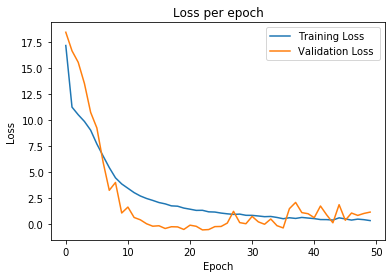

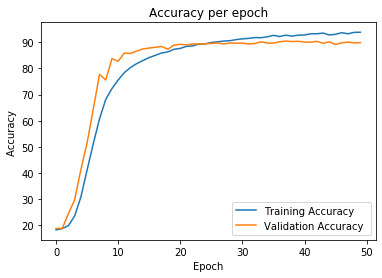

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model7.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            decoded, predicted = model7(images)
            loss1 = (criterion1(decoded,images)-val_mean_auto)/val_std_auto
            loss2 = (criterion2(predicted,labels)-val_class_mean)/val_class_std
            loss = loss1+loss2
            test_epoch_loss += loss.item()
            pred = predicted.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}, Testing Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

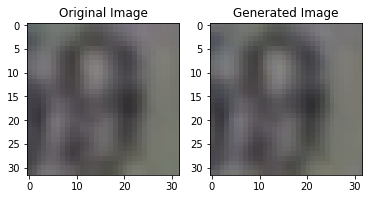

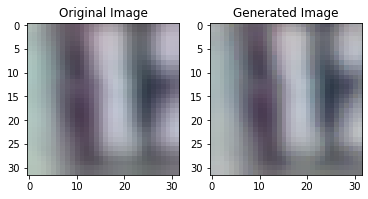

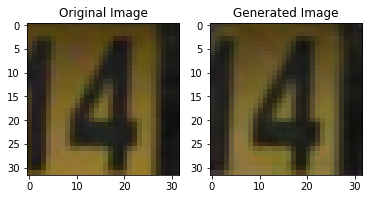

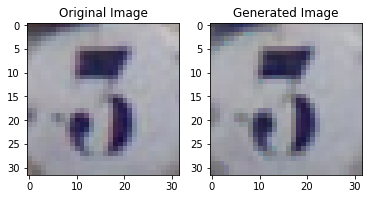

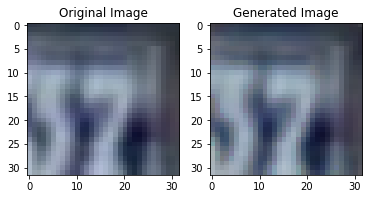

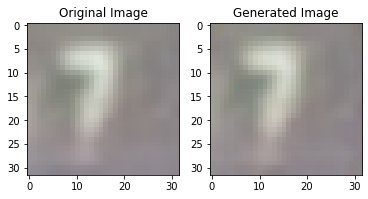

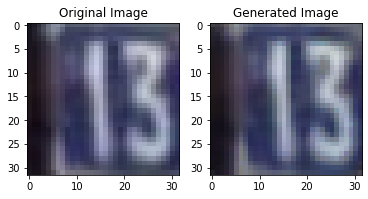

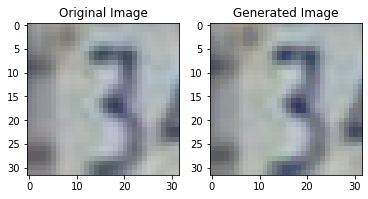

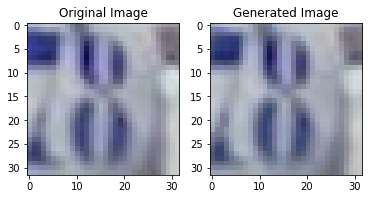

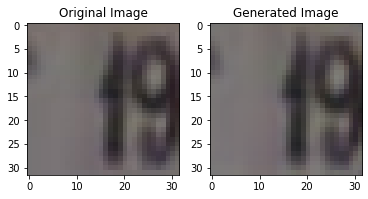

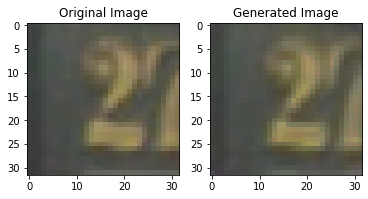

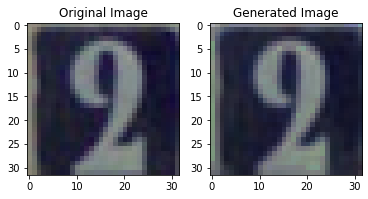

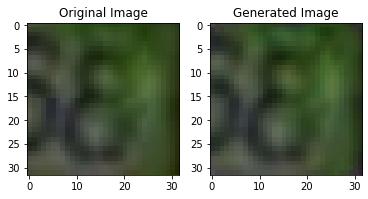

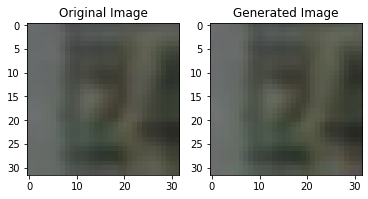

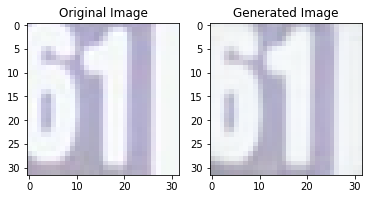

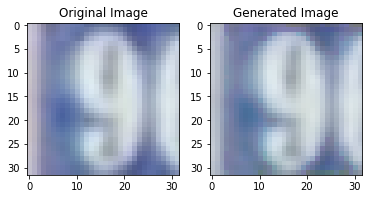

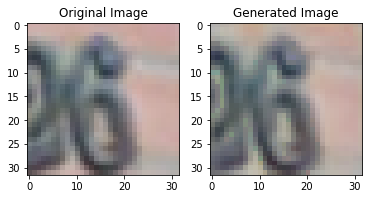

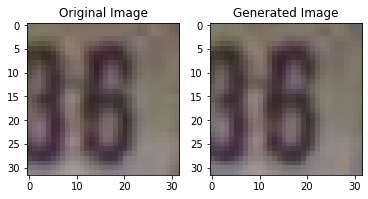

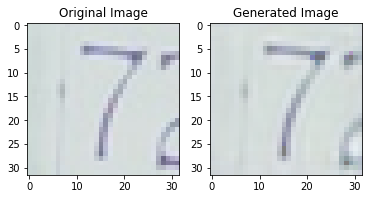

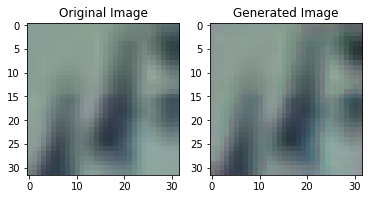

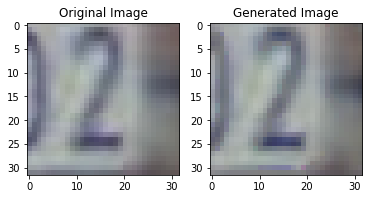

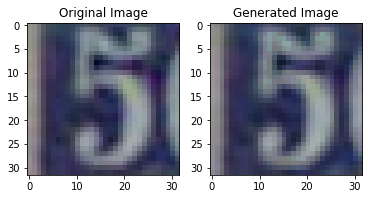

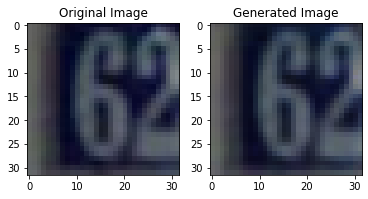

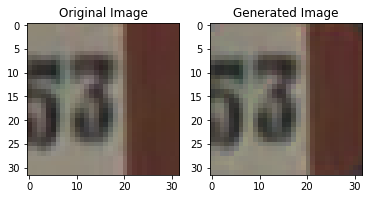

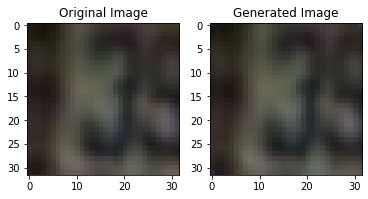

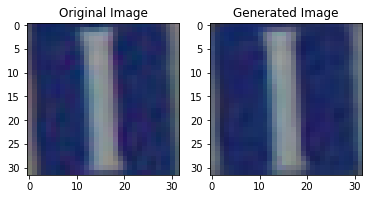

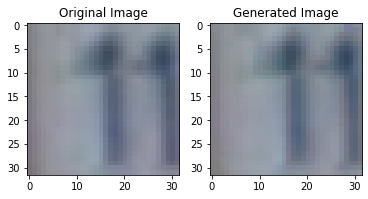

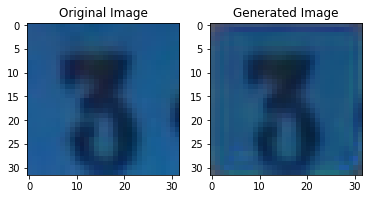

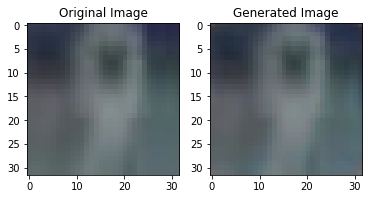

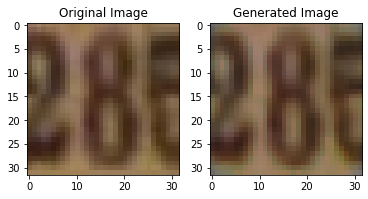

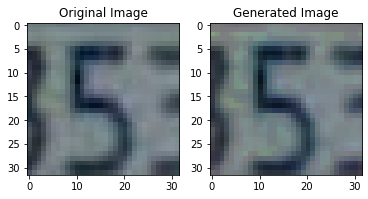

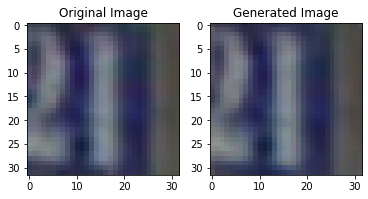

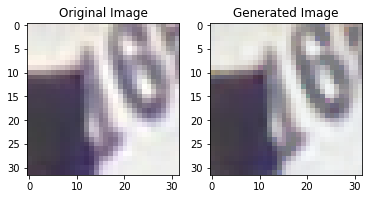

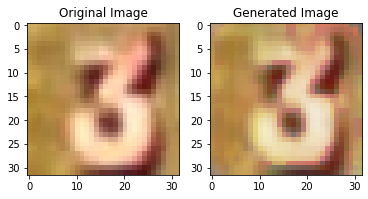

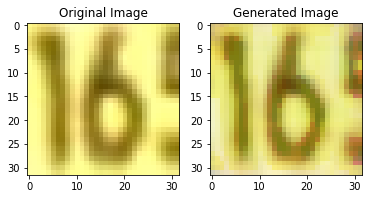

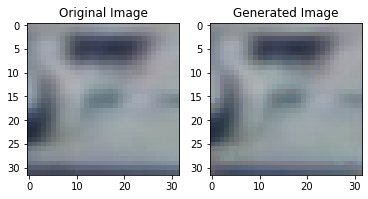

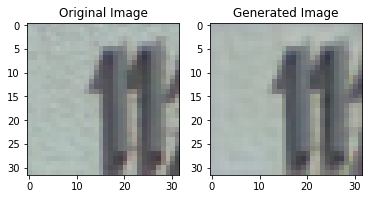

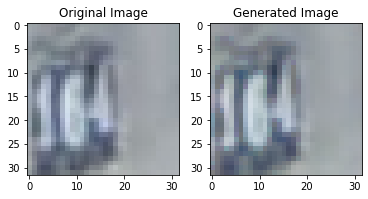

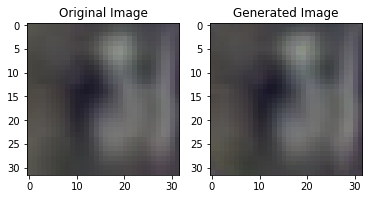

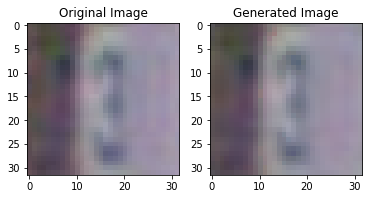

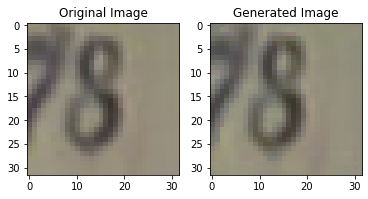

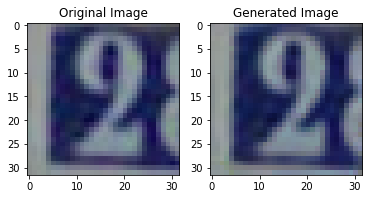

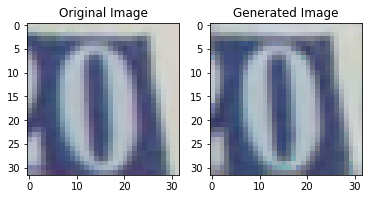

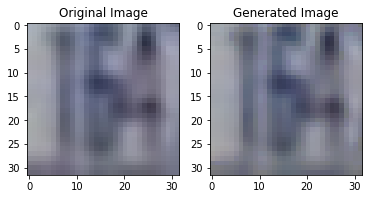

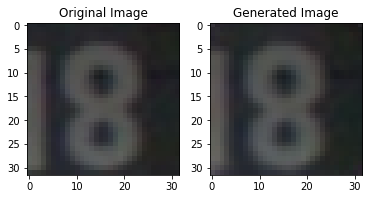

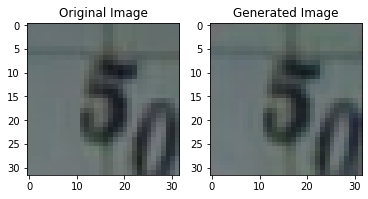

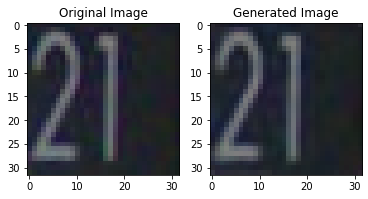

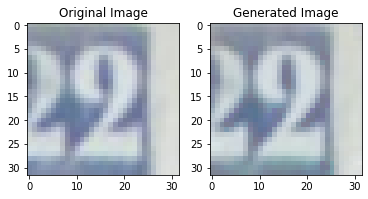

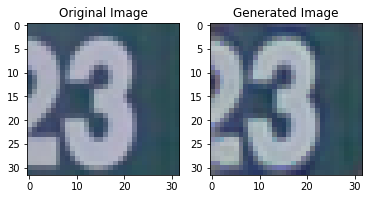

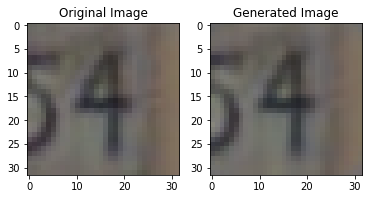

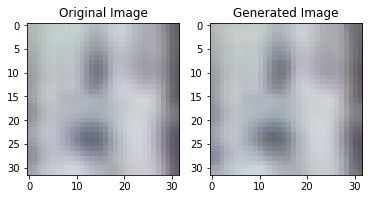

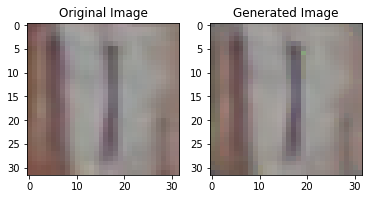

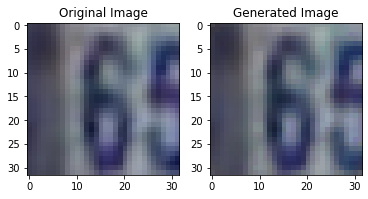

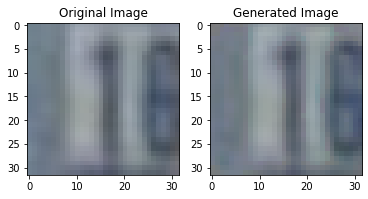

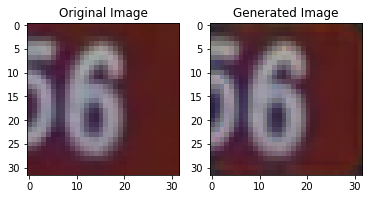

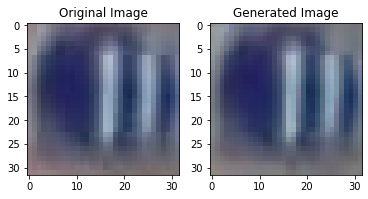

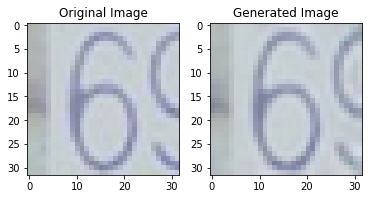

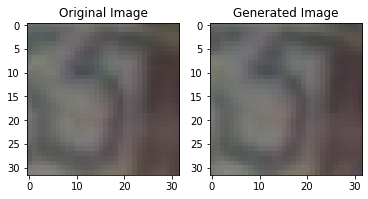

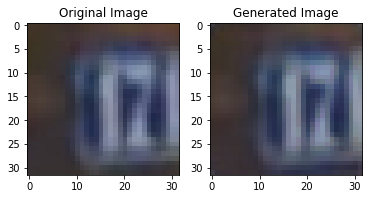

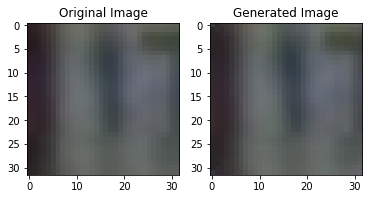

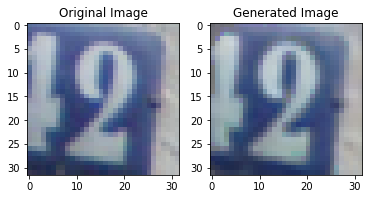

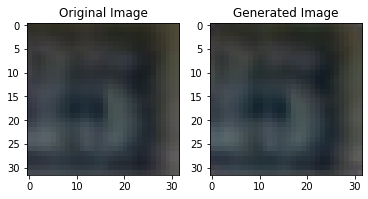

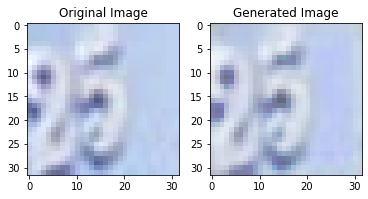

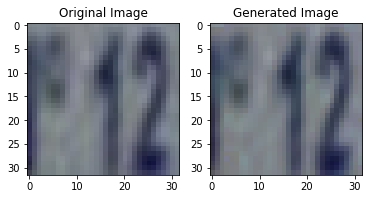

In [0]:
test_images, labels = next(iter(valloader))
test_images = test_images.cuda()
test_output, predicted = model7(test_images)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    image_input = test_images[i]
    image_input = np.transpose(test_images[i].cpu(),(1,2,0))
    image_output = test_output[i]
    image_output = np.transpose(test_output[i].cpu().detach(),(1,2,0))
    imgplot = plt.imshow(image_input)
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(image_output)
    plt.show()

# Mixed (two losses - no scaling of losses,feedback?)

In [8]:
model6 = Mixed().to(device)
#optimizer = optim.ASGD(model1.parameters(),lr=0.01)
#optimizer = optim.SGD(model6.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model6.parameters(),lr=0.001)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model6.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        generated_0,predicted_0 = model6(images) #first pass
        generated_1,predicted_1 = model6(images-generated_0) #feedback loop
        for i in range(3):
          generated_1,predicted_1 = model6(images-generated_1)
          loss1 = criterion1(generated_1,images)
          loss2 = criterion2(predicted_1,labels)
          loss = loss1+loss2*0.7
          loss.backward(retain_graph=True)
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model6.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model6(images) #first pass
            generated_1,predicted_1 = model6(images-generated_0) #feedback loop
            for i in range(3):
                generated_1,predicted_1 = model6(images-generated_1)
                loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss1+loss2*0.7
            val_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 0.8000, Training Accuracy: 37627/58605 (64%)
Average validation loss: 0.3379, Validation Accuracy: 12881/14652 (88%)
Epoch 1
Average training loss: 0.3724, Training Accuracy: 50679/58605 (86%)
Average validation loss: 0.2852, Validation Accuracy: 13171/14652 (90%)
Epoch 2
Average training loss: 0.2892, Training Accuracy: 52531/58605 (90%)
Average validation loss: 0.2674, Validation Accuracy: 13288/14652 (91%)
Epoch 3
Average training loss: 0.2320, Training Accuracy: 53906/58605 (92%)
Average validation loss: 0.2706, Validation Accuracy: 13312/14652 (91%)
Epoch 4
Average training loss: 0.1890, Training Accuracy: 54823/58605 (94%)
Average validation loss: 0.2765, Validation Accuracy: 13379/14652 (91%)
Epoch 5
Average training loss: 0.1554, Training Accuracy: 55631/58605 (95%)
Average validation loss: 0.3000, Validation Accuracy: 13359/14652 (91%)
Epoch 6
Average training loss: 0.1337, Training Accuracy: 56100/58605 (96%)
Average validation loss: 0.2999, Val

In [9]:
plt.rcParams["figure.figsize"] = (20,3)
inputs = []
outputs = []
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model6(test_images) #first pass
generated_1,predicted_1 = model6(test_images-generated_0) #feedback loop
for i in range(3):
    inputs.append(test_images-generated_1)
    generated_1,predicted_1 = model6(test_images-generated_1)
    outputs.append(generated_1)
_, predicted_label = torch.max(predicted_1, 1)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 7, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(np.transpose(test_images[i].cpu(),(1,2,0)))

    plot = fig.add_subplot(1, 7, 2)
    plot.set_title('Output from original image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(np.transpose(generated_0[i].cpu().detach(),(1,2,0)), cmap='gray')

    plot = fig.add_subplot(1, 7, 3)
    plot.set_title('Original minus first output ')
    imgplot = plt.imshow(np.transpose((test_images-generated_0)[i].cpu().detach(),(1,2,0)), cmap='gray')
    
    plot = fig.add_subplot(1, 7, 4)
    plot.set_title('(n-1) input ')
    imgplot = plt.imshow(np.transpose(inputs[1][i].cpu().detach(),(1,2,0)), cmap='gray')
    
    plot = fig.add_subplot(1, 7, 5)
    plot.set_title('(n-1) output ')
    imgplot = plt.imshow(np.transpose(outputs[1][i].cpu().detach(),(1,2,0)), cmap='gray')
    
    plot = fig.add_subplot(1, 7, 6)
    plot.set_title('Last input ')
    imgplot = plt.imshow(np.transpose(inputs[2][i].cpu().detach(),(1,2,0)), cmap='gray')
    
    plot = fig.add_subplot(1, 7, 7)
    plot.set_title('Final Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(np.transpose(generated_1[i].cpu().detach(),(1,2,0)))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")
model6.eval()
test_epoch_loss = 0
test_correct = 0
with torch.no_grad():
      for images, labels in testloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model6(images) #first pass
            generated_1,predicted_1 = model6(images-generated_0) #feedback loop
            for i in range(3):
                generated_1,predicted_1 = model6(images-generated_1)
                loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss1+loss2*0.7
            test_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(labels.view_as(pred)).sum().item()
test_epoch_loss /= len(testloader)
print('Average testing loss: {:.4f}, test Accuracy: {}/{} ({:.0f}%)'.format(
        test_epoch_loss, test_correct, len(testloader.dataset),
        100. * test_correct / len(testloader.dataset)))

In [5]:
model9 = Mixed().to(device)
#optimizer = optim.Adagrad(model9.parameters(),lr=0.01)
#optimizer = optim.ASGD(model9.parameters(),lr=0.01)
#optimizer = optim.SGD(model9.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model9.parameters(),lr=0.001)
training_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
for epoch in range(epochs):
    print("Epoch", epoch)
    #train
    model9.train()
    train_epoch_loss = 0
    train_correct = 0
    for images,labels in trainloader:
        images, labels = images.cuda(),labels.cuda()
        optimizer.zero_grad()
        generated_0,predicted_0 = model9(images) #first pass
        generated_1,predicted_1 = model9(images-generated_0*0.2) #feedback loop
        alpha = 0.3
        for i in range(5):
          generated_1,predicted_1 = model9(images-generated_1*alpha)
          alpha = alpha + 0.1
          #loss1 = criterion1(generated_1,images)
          loss2 = criterion2(predicted_1,labels)
          loss = loss2
          loss.backward(retain_graph=True)
        train_epoch_loss += loss.item()
        optimizer.step()
        pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(labels.view_as(pred)).sum().item()
        #if index % 10 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #epoch, index * len(images), len(trainloader.dataset),
                #100. * index / len(trainloader), loss.item()))
    train_epoch_loss /= len(trainloader)
    print('Average training loss: {:.4f}, Training Accuracy: {}/{} ({:.0f}%)'.format(
        train_epoch_loss, train_correct, len(trainloader.dataset),
        100. * train_correct / len(trainloader.dataset)))
    training_losses.append(train_epoch_loss)
    train_accuracies.append(100. * train_correct / len(trainloader.dataset))

    #validate
    model9.eval()
    val_epoch_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.cuda(),labels.cuda()
            generated_0,predicted_0 = model9(images) #first pass
            generated_1,predicted_1 = model9(images-generated_0*0.4) #feedback loop
            alpha = 0.5
            for i in range(5):
                generated_1,predicted_1 = model9(images-generated_1*alpha)
                alpha = alpha + 0.1
                #loss1 = criterion1(generated_1,images)
                loss2 = criterion2(predicted_1,labels)
                loss = loss2
            val_epoch_loss += loss.item()
            pred = predicted_1.max(1, keepdim=True)[1] # get the index of the max log-probability
            val_correct += pred.eq(labels.view_as(pred)).sum().item()
    val_epoch_loss /= len(valloader)
    print('Average validation loss: {:.4f}, Validation Accuracy: {}/{} ({:.0f}%)'.format(
        val_epoch_loss, val_correct, len(valloader.dataset),
        100. * val_correct / len(valloader.dataset)))
    val_losses.append(val_epoch_loss)
    val_accuracies.append(100. * val_correct / len(valloader.dataset))

Epoch 0
Average training loss: 1.0478, Training Accuracy: 38242/58605 (65%)
Average validation loss: 0.5899, Validation Accuracy: 11963/14652 (82%)
Epoch 1
Average training loss: 0.4852, Training Accuracy: 50216/58605 (86%)
Average validation loss: 0.4289, Validation Accuracy: 12741/14652 (87%)
Epoch 2
Average training loss: 0.3835, Training Accuracy: 52023/58605 (89%)
Average validation loss: 0.3729, Validation Accuracy: 13033/14652 (89%)
Epoch 3
Average training loss: 0.3186, Training Accuracy: 53052/58605 (91%)
Average validation loss: 0.3767, Validation Accuracy: 13011/14652 (89%)
Epoch 4
Average training loss: 0.2663, Training Accuracy: 53902/58605 (92%)
Average validation loss: 0.3721, Validation Accuracy: 13097/14652 (89%)
Epoch 5
Average training loss: 0.2224, Training Accuracy: 54696/58605 (93%)
Average validation loss: 0.3953, Validation Accuracy: 13137/14652 (90%)
Epoch 6
Average training loss: 0.1883, Training Accuracy: 55248/58605 (94%)
Average validation loss: 0.3919, Val

In [0]:
plot_graph(training_losses,val_losses,epochs,"Loss ")
plot_graph(train_accuracies,val_accuracies,epochs,"Accuracy ")

In [6]:
plt.rcParams["figure.figsize"] = (20,3)
inputs = []
outputs = []
test_images, labels = next(iter(testloader))
test_images = test_images.cuda()
generated_0,predicted_0 = model9(test_images) #first pass
generated_1,predicted_1 = model9(test_images-generated_0*0.4) #feedback loop
alpha = 0.5
for i in range(5):
    inputs.append(test_images-generated_1)
    generated_1,predicted_1 = model9(test_images-generated_1*alpha)
    alpha = alpha + 0.1
    outputs.append(generated_1)
_, predicted_label = torch.max(predicted_1, 1)

for i in range(len(test_images)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 8, 1)
    plot.set_title('Original Image ' + str(classes[labels[i]]))
    imgplot = plt.imshow(np.transpose(test_images[i].cpu(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 2)
    plot.set_title('Output from original image ')
    imgplot = plt.imshow(np.transpose(generated_0[i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 3)
    plot.set_title('Original minus first output ')
    imgplot = plt.imshow(np.transpose((test_images-generated_0)[i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 4)
    plot.set_title('(n-1) input ')
    imgplot = plt.imshow(np.transpose(inputs[1][i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 5)
    plot.set_title('(n-1) output ')
    imgplot = plt.imshow(np.transpose(outputs[1][i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 6)
    plot.set_title('Last input ')
    imgplot = plt.imshow(np.transpose(inputs[2][i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 7)
    plot.set_title('Final Generated Image ' + str(classes[predicted_label[i]]))
    imgplot = plt.imshow(np.transpose(generated_1[i].cpu().detach(),(1,2,0)), cmap='gray')
    plot = fig.add_subplot(1, 8, 8)
    plot.set_title('Diff last two outputs ')
    normalized_output = generated_1[i].cpu().detach()-outputs[1][i].cpu().detach()
    imgplot = plt.imshow(np.transpose(normalized_output,(1,2,0)), cmap='gray')
    
    plt.show()

Output hidden; open in https://colab.research.google.com to view.